#Klasifikasi Gambar Bunga Menggunakan Convolutional Neural Network (CNN)

###Langkah 1: Mount Google Drive

Mount Google Drive untuk mengakses dataset dan menyimpan file yang diperlukan seperti model, log TensorBoard, dan screenshot.

In [16]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Langkah 2: Path Dataset dan Setup ImageDataGenerator

Tetapkan path dataset di Google Drive, lalu gunakan ImageDataGenerator untuk preprocessing dan pembagian dataset menjadi training dan validation set.

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path ke folder dataset di Google Drive
dataset_path = "/content/drive/My Drive/Dataset/flowers"

# ImageDataGenerator untuk memuat dataset
data_gen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)  # Normalisasi dan split

# Data training
train_data = data_gen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),  # Resize gambar ke 128x128
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Data validasi
val_data = data_gen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Menampilkan label class
class_names = list(train_data.class_indices.keys())
print("Kelas yang tersedia:", class_names)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Kelas yang tersedia: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


###Langkah 3: Menampilkan Contoh Gambar dari Dataset

Visualisasikan beberapa gambar dari dataset untuk memastikan bahwa data berhasil dimuat.

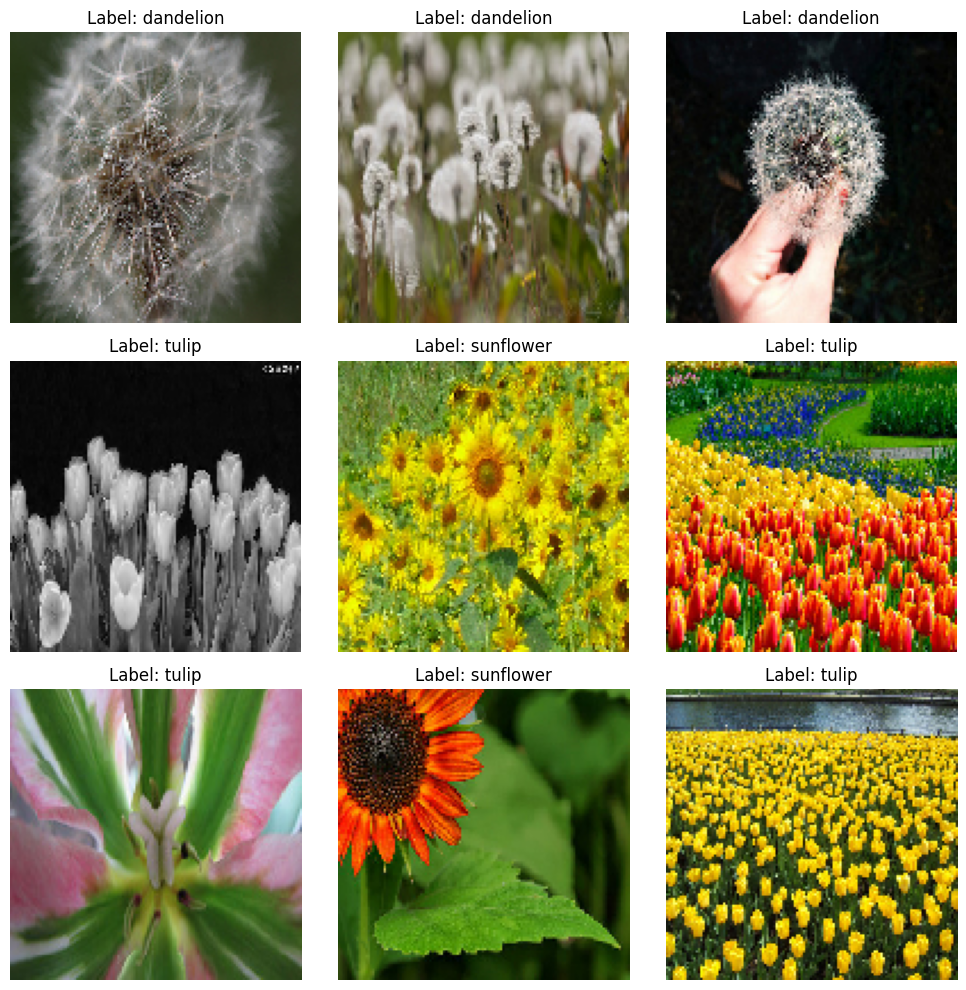

In [18]:
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan contoh gambar
def plot_examples(data_gen, num_examples=9):
    images, labels = next(data_gen)
    plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_idx = labels[i].argmax()  # Mendapatkan indeks kelas
        plt.title(f"Label: {class_names[label_idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Menampilkan 9 contoh gambar
plot_examples(train_data)

###Langkah 4: Membangun Model CNN

Membangun model CNN dengan 3 convolutional layers, pooling layers, dan dense layers.

In [19]:
from tensorflow.keras import layers, models

# Membangun model CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # Output layer sesuai jumlah kelas
])

# Menampilkan ringkasan model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

###Langkah 5: Mengkompilasi Model

Mengkompilasi model menggunakan optimizer Adam dan loss function categorical crossentropy.

In [20]:
# Mengkompilasi model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

###Langkah 6: Melatih Model dan Logging TensorBoard

Melatih model selama beberapa epoch sambil mencatat log untuk TensorBoard.

In [21]:
from tensorflow.keras.callbacks import TensorBoard
import os

# Folder untuk log TensorBoard
log_dir = "/content/drive/My Drive/Dataset/tensorboard_logs"
os.makedirs(log_dir, exist_ok=True)

# Callback TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Melatih model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=[tensorboard_callback]
)

Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.3534 - loss: 1.4266 - val_accuracy: 0.5395 - val_loss: 1.1652
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.6117 - loss: 1.0130 - val_accuracy: 0.5895 - val_loss: 0.9930
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6549 - loss: 0.8641 - val_accuracy: 0.6372 - val_loss: 0.9097
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.7433 - loss: 0.6572 - val_accuracy: 0.6314 - val_loss: 0.9593
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.8006 - loss: 0.5199 - val_accuracy: 0.6256 - val_loss: 1.0733


###Langkah 7: Visualisasi Proses Training

Plot training dan validation loss serta accuracy untuk memantau performa model.

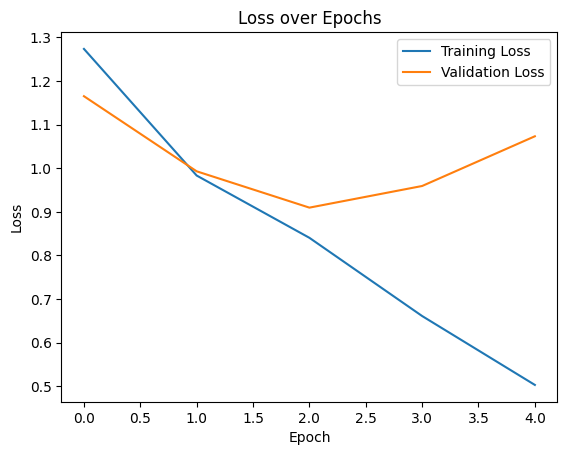

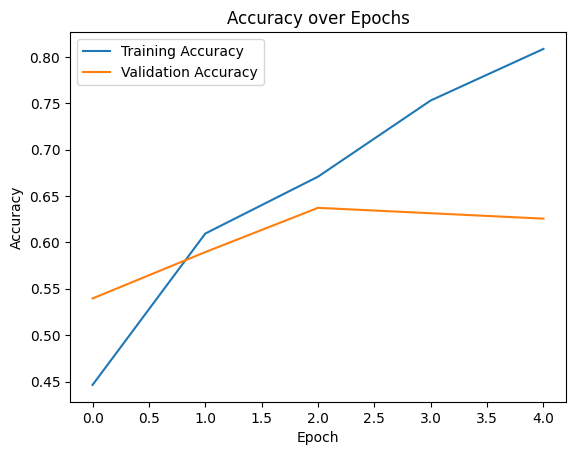

In [23]:
# Plot training dan validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('/content/drive/My Drive/Dataset/Screenshot/training_loss_plot.png')  # Simpan plot
plt.show()

# Plot training dan validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.savefig('/content/drive/My Drive/Dataset/Screenshot/training_accuracy_plot.png')  # Simpan plot
plt.show()

###Langkah 8: Mengevaluasi dan Menyimpan Model

Evaluasi performa model pada data validasi dan simpan model ke Google Drive.

In [24]:
# Mengevaluasi model
loss, accuracy = model.evaluate(val_data, verbose=2)
print(f"Validation accuracy: {accuracy:.2f}")

# Menyimpan model
model_path = "/content/drive/My Drive/Dataset/flowers_cnn_model.h5"
model.save(model_path)
print(f"Model saved to {model_path}")

27/27 - 13s - 475ms/step - accuracy: 0.6256 - loss: 1.0733


Validation accuracy: 0.63
Model saved to /content/drive/My Drive/Dataset/flowers_cnn_model.h5
